# Import libraries 

In [0]:
#imports
import scipy
import math as mt
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import scale
#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#cross validation
from sklearn.model_selection import train_test_split
from math import sqrt
import random 

## Table Of Content:

* [1. Import Dataset](#Import)   
* [2. Feature engineering](#Feature)   
* [3. Cascading](#Cascading)   
    *  [3.1 Building](##Building)   
    *  [3.2 Latitude](##Latitude) 
    *  [3.3 Longitude](##Longitude) 
    *  [3.4 Floor](##Floor) 

# <a class="anchor" id="Import"> 1. Import dataset </a>

In [0]:
random.seed(203)

#Importing dataset
wifi = pd.read_csv("https://raw.githubusercontent.com/Layden23/wifi-python/master/Datasets/trainingData.csv", header = 0)
wifi["type"] = "train"
validate = pd.read_csv("https://raw.githubusercontent.com/Layden23/wifi-python/master/Datasets/validationData.csv", header = 0)
validate["type"] = "test"
twifi = wifi.append(validate)

In [0]:
wifi = wifi.iloc[:,0:520].drop_duplicates(subset=None, keep='first')
validate = validate.iloc[:,0:520].drop_duplicates(subset=None, keep="first")

In [0]:
twifi.iloc[:, 0:520] = np.where(twifi.iloc[:, 0:520] <= 0,
         twifi.iloc[:, 0:520] + 105,
         twifi.iloc[:, 0:520] - 100)

In [0]:
twifi.iloc[:,0:520] = twifi.iloc[:,0:520].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],17)
twifi.iloc[:,0:520] = twifi.iloc[:,0:520] - 16 
twifi.iloc[:,0:520] = twifi.iloc[:,0:520].replace(-16,0)

In [0]:
norm = Normalizer(norm="max").fit(twifi.iloc[:,0:520])
twifi.iloc[:,0:520] = norm.transform(twifi.iloc[:,0:520])
stand = MinMaxScaler().fit(twifi.iloc[:,0:520])
twifi.iloc[:,0:520] = stand.transform(twifi.iloc[:,0:520])

In [0]:
validate = twifi[twifi["type"] == "test"]
wifi = twifi[twifi["type"] == "train"]


In [7]:
wifi["LONGITUDE"] = - wifi["LONGITUDE"]
validate["LONGITUDE"]= - validate["LONGITUDE"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# <a class="anchor" id="Feature"> 2. Feature engineering </a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



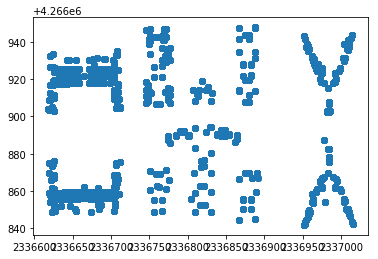

In [8]:
angle =np.arctan(wifi["LATITUDE"][0]/wifi["LONGITUDE"][0])
angle = angle/mt.pi
LONGITUDE = wifi["LONGITUDE"]*np.cos(angle) + wifi["LATITUDE"]*np.sin(angle)
LATITUDE = wifi["LATITUDE"]*np.cos(angle) - wifi["LONGITUDE"]*np.sin(angle)
plt.scatter(LONGITUDE,LATITUDE)
wifi["LONGITUDE"] = LONGITUDE
wifi["LATITUDE"] = LATITUDE
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



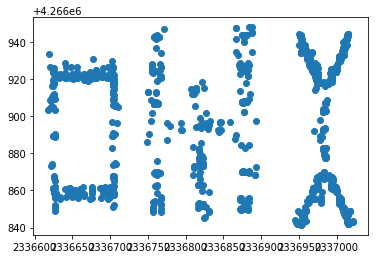

In [9]:
vlong = validate["LONGITUDE"]*np.cos(angle) +validate["LATITUDE"]*np.sin(angle)
vlat = validate["LATITUDE"]*np.cos(angle) - validate["LONGITUDE"]*np.sin(angle)
validate["LONGITUDE"] = vlong
validate["LATITUDE"] = vlat
plt.scatter(vlong,vlat)

In [0]:
swifi = []
for i in wifi.iloc[:,0:520]:
    swifi.append(sum(wifi[i]))
svalidate = []
for i in validate.iloc[:,0:520]:
    svalidate.append(sum(validate[i]))
sumwifi = pd.DataFrame({'col1': [i for i in wifi.iloc[:,0:520]] , 'col2': swifi})
sumvalidate = pd.DataFrame({'col1': [i for i in validate.iloc[:,0:520]] , 'col2': svalidate})

nosignal = np.where(sumwifi['col2']==0)
vnosignal = np.where(sumvalidate["col2"]==0)
badwaps = sumwifi.iloc[nosignal[0],:]
vadwaps = sumvalidate.iloc[vnosignal[0],:]  

In [0]:
wifi = wifi.drop(vadwaps["col1"], axis=1)
validate = validate.drop(vadwaps["col1"], axis = 1)
n = 520 - len(vadwaps)

# <a class="anchor" id="Cascading"> 3. Cascading </a>

## <a class="anchor" id="Building"> 3.1 Building </a>

In [0]:
#features
X = wifi.iloc[:,0:n]
pca = PCA(0.999)
pca.fit(twifi.iloc[:,0:n])
pcX = pd.DataFrame(pca.transform(X))
y = wifi["BUILDINGID"]
vx = validate.iloc[:,0:n] 
pcvx = pd.DataFrame(pca.transform(vx))
vy = validate["BUILDINGID"]

In [13]:
#Models
knn = KNeighborsClassifier(n_neighbors= 5, metric = "euclidean", weights="distance")
knnm = KNeighborsClassifier(n_neighbors= 5, metric = "manhattan", weights="distance")
knn.fit(pcX, y)
knnm.fit(pcX, y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [14]:
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(pcX, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
fpreds = rf.predict(pcvx)
knnpreds = knn.predict(pcvx)
knnmpreds = knnm.predict(pcvx)


In [16]:
# initialize list of lists 
performance = [['rf', accuracy_score(vy, fpreds), cohen_kappa_score(vy, fpreds)],
               ['kNN', accuracy_score(vy, knnpreds), cohen_kappa_score(vy, knnpreds)],
               ['kNNm', accuracy_score(vy, knnmpreds), cohen_kappa_score(vy, knnmpreds)]] 
  
# Create the pandas DataFrame 
df_perf = pd.DataFrame(performance, columns = ['Model', 'Accuracy','Kappa'])
df_perf

,Model,Accuracy,Kappa
0,rf,1.0000,1.000000
1,kNN,0.9973,0.995735
2,kNNm,0.9973,0.995735


In [17]:
confusion_matrix(vy, knnpreds, labels=None, sample_weight=None)

array([[534,   0,   2],
       [  0, 306,   1],
       [  0,   0, 268]])

In [18]:
confusion_matrix(vy, fpreds, labels=None, sample_weight=None)

array([[536,   0,   0],
       [  0, 307,   0],
       [  0,   0, 268]])

## <a class="anchor" id="Longitude"> 3.2 Longitude </a>

In [0]:
X1 = X.copy()
X1["BUILDINGID"] = wifi["BUILDINGID"]
y1 = wifi["LONGITUDE"]
vx1 = vx.copy()
vx1["BUILDINGID"] = rf.predict(pcvx)
vy1 = validate["LONGITUDE"]

In [20]:
knn1 = KNeighborsRegressor(n_neighbors= 10, metric = "euclidean", weights="distance")
knnm1 = KNeighborsRegressor(n_neighbors= 10, metric = "manhattan", weights="distance")
knn1.fit(X1, y1)
knnm1.fit(X1, y1)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

In [21]:
rf1 = RandomForestRegressor(n_estimators = 100)
rf1.fit(X1, y1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
rfpreds1 = rf1.predict(vx1)
knnpreds1 = knn1.predict(vx1)
knnmpreds1 = knnm1.predict(vx1)


In [23]:
# initialize list of lists 
performance1 = [['Forest', sqrt(mean_squared_error(vy1, rfpreds1)), r2_score(vy1, rfpreds1),mean_absolute_error(vy1, rfpreds1)],
               ['kNN', sqrt(mean_squared_error(vy1, knnpreds1)), r2_score(vy1, knnpreds1),mean_absolute_error(vy1, knnpreds1)],
                ['kNNm', sqrt(mean_squared_error(vy1, knnmpreds1)), r2_score(vy1, knnmpreds1),mean_absolute_error(vy1, knnmpreds1)]]
  
# Create the pandas DataFrame 
df_perf1 = pd.DataFrame(performance1, columns = ['Model', "RMSE","r2","MAE"])
df_perf1

,Model,RMSE,r2,MAE
0,Forest,9.761704,0.994792,6.142442
1,kNN,7.940597,0.996554,4.576782
2,kNNm,10.377524,0.994115,5.427416


## <a class="anchor" id="Latitude"> 3.3 Latitude </a>

In [0]:
X2 = X.copy()
X2["BUILDINGID"] = wifi["BUILDINGID"]
y2 = wifi["LATITUDE"]
vx2 = vx.copy()
vx2["BUILDINGID"] = rf.predict(pcvx)
vy2 = validate["LATITUDE"]

In [25]:
knn2 = KNeighborsRegressor(n_neighbors= 9, metric = "euclidean", weights="distance")
knn2.fit(X2, y2)
knnm2 = KNeighborsRegressor(n_neighbors= 9, metric = "manhattan", weights="distance")
knnm2.fit(X2, y2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

In [26]:
rf2 = RandomForestRegressor(n_estimators = 100)
rf2.fit(X2, y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
rfpreds2 = rf2.predict(vx2)
knnpreds2 = knn2.predict(vx2)
knnmpreds2 = knnm2.predict(vx2)


In [28]:
# initialize list of lists 
performance2 = [['Forest', sqrt(mean_squared_error(vy2, rfpreds2)), r2_score(vy2, rfpreds2),mean_absolute_error(vy2, rfpreds2)],
               ['kNN', sqrt(mean_squared_error(vy2, knnpreds2)), r2_score(vy2, knnpreds2),mean_absolute_error(vy2, knnpreds2)],
                ['kNNm', sqrt(mean_squared_error(vy2, knnmpreds2)), r2_score(vy2, knnpreds2),mean_absolute_error(vy2, knnmpreds2)]]
  
# Create the pandas DataFrame 
print("LATITUDE")
df_perf2 = pd.DataFrame(performance2, columns = ['Model', 'RMSE',"r2","MAE"])
df_perf2

LATITUDE


,Model,RMSE,r2,MAE
0,Forest,9.379052,0.918015,5.805612
1,kNN,7.176084,0.952005,4.190281
2,kNNm,7.863625,0.952005,4.502792


## <a class="anchor" id="FLOOR"> 3.4 Floor </a>

In [0]:
X3 = X.copy()
X3["BUILDINGID"] = wifi["BUILDINGID"]
y3 = wifi["FLOOR"]
vx3 = vx.copy()
vx3["BUILDINGID"] = rf.predict(pcvx)
vy3 = validate["FLOOR"]

In [30]:
knn3 = KNeighborsClassifier(n_neighbors= 9, metric = "euclidean", weights="distance")
knn3.fit(X3, y3)
knnm3 = KNeighborsClassifier(n_neighbors= 9, metric = "manhattan", weights="distance")
knnm3.fit(X3, y3)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [31]:
rf3 = RandomForestClassifier(n_estimators = 100)
rf3.fit(X3, y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfpreds3 = rf3.predict(vx3)
knnpreds3 = knn3.predict(vx3)
knnmpreds3 = knnm3.predict(vx3)

In [33]:
# initialize list of lists 
performance3 = [['rf', accuracy_score(vy3, rfpreds3), cohen_kappa_score(vy3, rfpreds3)],
               ['kNN', accuracy_score(vy3, knnpreds3), cohen_kappa_score(vy3, knnpreds3)],
                ['kNNm', accuracy_score(vy3, knnmpreds3), cohen_kappa_score(vy3, knnmpreds3)]] 
# Create the pandas DataFrame 
df_perf3 = pd.DataFrame(performance3, columns = ['Model', "Accuracy","Kappa"])
df_perf3

,Model,Accuracy,Kappa
0,rf,0.932493,0.905589
1,kNN,0.958596,0.941968
2,kNNm,0.920792,0.889741


In [0]:
floor_matrix = confusion_matrix(vy3, knnpreds3, labels = None, sample_weight=None)

In [35]:
floor_matrix

array([[125,   6,   1,   0,   0],
       [  6, 439,  13,   4,   0],
       [  0,   6, 297,   2,   1],
       [  0,   0,   3, 168,   1],
       [  0,   0,   0,   3,  36]])

## Plots

In [0]:
results = pd.DataFrame()
results["BUILDINGID"] = fpreds
results["LATITUDE"]  = knnpreds1
results["LONGITUDE"] = knnpreds2
results["FLOOR"] = knnpreds3
results["type"] = "pred"
res = pd.DataFrame()
res["BUILDINGID"] = vy
res["LATITUDE"]  = vy1
res["LONGITUDE"] = vy2
res["FLOOR"] = vy3
res["type"] = "real"
####
fresults = results.append(res)
####
results["AE_Lat"] = abs(knnpreds1 - vy1)
results["RE_Lat"] = (abs(knnpreds1 - vy1))/vy1
results["AE_Long"] = abs(knnpreds2 -vy2)
results["RE_Long"] = abs((knnpreds2 - vy2))/vy2

In [37]:
print("MRE Lat:",np.mean(results["RE_Lat"]))
print("MRE Long:",np.mean(results["RE_Long"]))

MRE Lat: 1.958542697331384e-06
MRE Long: 9.820448869667857e-07


In [38]:
fig = px.histogram(results, x="AE_Lat")
fig.show()

In [39]:
fig = px.histogram(results, x="AE_Long")
fig.show()

In [40]:
fig = px.scatter(results, x="LATITUDE", y="RE_Lat")
fig.show()

In [41]:
fig = px.scatter(results, x="LONGITUDE", y="RE_Long")
fig.show()

In [42]:
fig = px.scatter_3d(results, x = 'LONGITUDE', y = 'LATITUDE', z = 'FLOOR', color = "BUILDINGID")
fig.show()